# Detekcja Upadków - DenseNet121 + LSTM

## 1. Pobranie zbiorów danych

## 2. Importy i setup

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import glob
import os
import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
np.random.seed(42)
torch.manual_seed(42)

print(f"Device: {device}")
print(f"PyTorch: {torch.__version__}")

Device: cuda
PyTorch: 2.9.0+cu126


## 3. Dataset loader i preprocessing

In [3]:
class FallDetectionDataset(Dataset):
    def __init__(self, sequence_length=40, transform=None):
        self.sequence_length = sequence_length
        self.transform = transform

        self.sequences = []
        self.labels = []

        self.load_sequences('adl', 0)
        self.load_sequences('fall', 1)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        frames_paths = self.sequences[idx]
        label = self.labels[idx]

        num_frames = len(frames_paths)
        if num_frames >= self.sequence_length:
            indices = np.linspace(0, num_frames - 1, self.sequence_length, dtype=int)
            sampled_paths = [frames_paths[i] for i in indices]
        else:
            sampled_paths = list(frames_paths)
            while len(sampled_paths) < self.sequence_length:
                sampled_paths.append(frames_paths[-1])

        frames = []
        for frame_path in sampled_paths:
            img = Image.open(frame_path).convert('RGB')
            if self.transform:
                img = self.transform(img)
            frames.append(img)

        return torch.stack(frames), label

    def load_sequences(self, folder_name, label):
        class_path = os.path.join('data', folder_name)

        for seq_folder in sorted(glob.glob(os.path.join(class_path, '*'))):
            if not os.path.isdir(seq_folder):
                continue

            frames = sorted(glob.glob(os.path.join(seq_folder, '*.png')))

            if len(frames) > 0:
                self.sequences.append(frames)
                self.labels.append(label)


train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = FallDetectionDataset(sequence_length = 48, transform=train_transform)
print(f"Sekwencji: {len(dataset)}")

Sekwencji: 70


## 4. Podział danych na train/test

In [4]:
indices = np.arange(len(dataset))
labels = dataset.labels

train_indices, test_indices = train_test_split(
    indices,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

## 5. Architektura modelu

In [5]:
class FallDetectionModel(nn.Module):
    def __init__(self, hidden_size=256, num_layers=2, dropout=0.3):
        super().__init__()

        densenet = models.densenet121(weights='DEFAULT')
        self.cnn = densenet.features
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        for param in self.cnn.parameters():
            param.requires_grad = False

        self.lstm = nn.LSTM(
            input_size=1024,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 2)
        )

    def unfreeze_cnn(self):
        blocks = list(self.cnn.children())
        for block in blocks[-4:]:
            for param in block.parameters():
                param.requires_grad = True

    def forward(self, x):
        B, T, C, H, W = x.shape

        x = x.reshape(B * T, C, H, W)
        x = self.cnn(x)
        x = self.avgpool(x)
        x = x.flatten(1)

        x = x.reshape(B, T, -1)
        x, _ = self.lstm(x)

        x = x[:, -1, :]
        x = self.classifier(x)

        return x

model = FallDetectionModel(hidden_size=256, dropout=0.3)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 91.1MB/s]


## 6. Funkcje treningu i walidacji

In [6]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    loss_total = 0
    correct = 0
    total = 0

    for frames, labels in loader:
        frames, labels = frames.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(frames)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_total += loss.item()
        correct += (torch.argmax(outputs, 1) == labels).sum().item()
        total += labels.size(0)

    avg_loss = loss_total / len(loader)
    avg_acc = correct / total

    return avg_loss, avg_acc

def validate(model, loader, criterion, device):
    model.eval()
    loss_total = 0
    correct = 0
    total = 0
    all_pred, all_true = [], []

    with torch.no_grad():
        for frames, labels in loader:
            frames, labels = frames.to(device), labels.to(device)
            outputs = model(frames)
            loss = criterion(outputs, labels)

            loss_total += loss.item()
            preds = torch.argmax(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_pred.extend(preds.cpu().numpy())
            all_true.extend(labels.cpu().numpy())

    avg_loss = loss_total / len(loader)
    avg_acc = correct / total

    return avg_loss, avg_acc, all_pred, all_true

def train_model(model, train_loader, val_loader, epochs, device, criterion, optimizer, scheduler):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0

    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)

        scheduler.step(val_loss)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

        print(f"Epoch {epoch+1:2d}/{epochs}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

    model.load_state_dict(torch.load('best_model.pth'))
    return history, model

## 7. Cross-validation - trening

In [7]:
QUICK_TEST = False

N_SPLITS = 2 if QUICK_TEST else 5
BATCH_SIZE = 4
BASE_EPOCHS = 10 if QUICK_TEST else 15
LR = 1e-4

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
fold_results = []
all_predictions = []
all_labels = []

train_labels = [dataset.labels[i] for i in train_indices]
n_adl = sum(1 for l in train_labels if l == 0)
n_fall = sum(1 for l in train_labels if l == 1)
class_weights = [1 / np.sqrt(n_adl), 1 / np.sqrt(n_fall)]

class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

for fold, (train_fold_idx, val_fold_idx) in enumerate(skf.split(train_indices, train_labels)):
    train_idx = train_indices[train_fold_idx]
    val_idx = train_indices[val_fold_idx]
    print(f"{'='*60}")
    print(f"Fold {fold+1}/{N_SPLITS}")
    print(f"{'='*60}\n")

    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(
        FallDetectionDataset(48, val_transform),
        val_idx
    )

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    model = FallDetectionModel(hidden_size=256, dropout=0.3).to(device)

    optimizer = optim.Adam(model.parameters(), lr=LR)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3)

    history, model = train_model(
        model,
        train_loader,
        val_loader,
        epochs=BASE_EPOCHS,
        device=device,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler
    )

    val_loss, val_acc, preds, true = validate(model, val_loader, criterion, device)

    precision = precision_score(true, preds, zero_division=0)
    recall = recall_score(true, preds, zero_division=0)
    f1 = f1_score(true, preds, zero_division=0)

    fold_results.append({
        'loss': val_loss,
        'acc': val_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })
    all_predictions.extend(preds)
    all_labels.extend(true)

    print(f"  Wyniki fold {fold+1}:")
    print(f"  Loss:      {val_loss:.4f}")
    print(f"  Accuracy:  {val_acc:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}\n")

print(f"{'='*60}")
print("ŚREDNIE WYNIKI Z CV")
print(f"{'='*60}")
print(f"Loss:      {np.mean([r['loss'] for r in fold_results]):.4f} += {np.std([r['loss'] for r in fold_results]):.4f}")
print(f"Accuracy:  {np.mean([r['acc'] for r in fold_results]):.4f} += {np.std([r['acc'] for r in fold_results]):.4f}")
print(f"Precision: {np.mean([r['precision'] for r in fold_results]):.4f} += {np.std([r['precision'] for r in fold_results]):.4f}")
print(f"Recall:    {np.mean([r['recall'] for r in fold_results]):.4f} += {np.std([r['recall'] for r in fold_results]):.4f}")
print(f"F1-Score:  {np.mean([r['f1'] for r in fold_results]):.4f} += {np.std([r['f1'] for r in fold_results]):.4f}")

Fold 1/5

Epoch  1/15: train_loss=0.6987, train_acc=0.4318, val_loss=0.6852, val_acc=0.4167
Epoch  2/15: train_loss=0.6723, train_acc=0.5000, val_loss=0.6472, val_acc=0.6667
Epoch  3/15: train_loss=0.6307, train_acc=0.8409, val_loss=0.5916, val_acc=0.9167
Epoch  4/15: train_loss=0.5786, train_acc=0.9773, val_loss=0.4995, val_acc=1.0000
Epoch  5/15: train_loss=0.4416, train_acc=0.9545, val_loss=0.3253, val_acc=1.0000
Epoch  6/15: train_loss=0.2568, train_acc=0.9773, val_loss=0.1353, val_acc=1.0000
Epoch  7/15: train_loss=0.3122, train_acc=0.9091, val_loss=0.0723, val_acc=1.0000
Epoch  8/15: train_loss=0.1171, train_acc=0.9545, val_loss=0.0518, val_acc=1.0000
Epoch  9/15: train_loss=0.1170, train_acc=0.9545, val_loss=0.0419, val_acc=1.0000
Epoch 10/15: train_loss=0.0677, train_acc=0.9773, val_loss=0.0325, val_acc=1.0000
Epoch 11/15: train_loss=0.0473, train_acc=1.0000, val_loss=0.0226, val_acc=1.0000
Epoch 12/15: train_loss=0.0218, train_acc=1.0000, val_loss=0.0162, val_acc=1.0000
Epoch 

## 8. Trening finalnego modelu z fine-tuningiem

Po cross-validation trenujemy finalny model, na całym zbiorze treningowym z odmrożonymi warstwami CNN.

In [8]:
FINETUNE_EPOCHS = 5 if QUICK_TEST else 10

train_dataset_full = Subset(dataset, train_indices)
val_dataset_for_final = Subset(
    FallDetectionDataset(48, val_transform),
    train_indices[:len(train_indices)//5]
)

train_loader_full = DataLoader(train_dataset_full, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader_final = DataLoader(val_dataset_for_final, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

final_model = FallDetectionModel(hidden_size=256, dropout=0.3).to(device)

print("="*60)
print("Trening bazowy na całym zbiorze treningowym")
print("="*60)

optimizer_final = optim.Adam(final_model.parameters(), lr=LR)
scheduler_final = optim.lr_scheduler.ReduceLROnPlateau(optimizer_final, 'min', factor=0.5, patience=3)

history_base, final_model = train_model(
    final_model,
    train_loader_full,
    val_loader_final,
    epochs=BASE_EPOCHS,
    device=device,
    criterion=criterion,
    optimizer=optimizer_final,
    scheduler=scheduler_final
)

print("\n" + "="*60)
print("Fine-tuning")
print("="*60)

final_model.unfreeze_cnn()

optimizer_finetune = optim.Adam([
    {'params': final_model.cnn.parameters(), 'lr': LR * 0.1},
    {'params': final_model.lstm.parameters(), 'lr': LR},
    {'params': final_model.classifier.parameters(), 'lr': LR}
])
scheduler_finetune = optim.lr_scheduler.ReduceLROnPlateau(optimizer_finetune, 'min', factor=0.5, patience=2)

history_finetune, final_model = train_model(
    final_model,
    train_loader_full,
    val_loader_final,
    epochs=FINETUNE_EPOCHS,
    device=device,
    criterion=criterion,
    optimizer=optimizer_finetune,
    scheduler=scheduler_finetune
)

history = {
    'train_loss': history_base['train_loss'] + history_finetune['train_loss'],
    'train_acc': history_base['train_acc'] + history_finetune['train_acc'],
    'val_loss': history_base['val_loss'] + history_finetune['val_loss'],
    'val_acc': history_base['val_acc'] + history_finetune['val_acc']
}

Trening bazowy na całym zbiorze treningowym
Epoch  1/15: train_loss=0.6947, train_acc=0.4286, val_loss=0.6667, val_acc=0.4545
Epoch  2/15: train_loss=0.6506, train_acc=0.6250, val_loss=0.6035, val_acc=0.9091
Epoch  3/15: train_loss=0.5684, train_acc=0.9464, val_loss=0.4665, val_acc=1.0000
Epoch  4/15: train_loss=0.4125, train_acc=0.9643, val_loss=0.2327, val_acc=1.0000
Epoch  5/15: train_loss=0.1678, train_acc=0.9821, val_loss=0.0626, val_acc=1.0000
Epoch  6/15: train_loss=0.1552, train_acc=0.9464, val_loss=0.0242, val_acc=1.0000
Epoch  7/15: train_loss=0.5121, train_acc=0.8393, val_loss=0.0328, val_acc=1.0000
Epoch  8/15: train_loss=0.0988, train_acc=0.9643, val_loss=0.0342, val_acc=1.0000
Epoch  9/15: train_loss=0.2038, train_acc=0.9286, val_loss=0.0371, val_acc=1.0000
Epoch 10/15: train_loss=0.0447, train_acc=1.0000, val_loss=0.0325, val_acc=1.0000
Epoch 11/15: train_loss=0.0485, train_acc=1.0000, val_loss=0.0290, val_acc=1.0000
Epoch 12/15: train_loss=0.0669, train_acc=0.9821, val_

## 9. Ewaluacja na zbiorze testowym

In [9]:
test_dataset = Subset(
    FallDetectionDataset(48, val_transform),
    test_indices
)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

test_loss, test_acc, test_preds, test_true = validate(final_model, test_loader, criterion, device)

test_precision = precision_score(test_true, test_preds, zero_division=0)
test_recall = recall_score(test_true, test_preds, zero_division=0)
test_f1 = f1_score(test_true, test_preds, zero_division=0)

print(f"Test Loss:      {test_loss:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall:    {test_recall:.4f}")
print(f"Test F1-Score:  {test_f1:.4f}")

Test Loss:      0.2301
Test Accuracy:  1.0000
Test Precision: 1.0000
Test Recall:    1.0000
Test F1-Score:  1.0000


## 10. Przykładowe predykcje

In [10]:
class_names = ['ADL', 'FALL']

def get_sequence_folder_path(sample_idx):
    frames_paths = dataset.sequences[sample_idx]
    return os.path.dirname(frames_paths[0])

correct_indices = [i for i, (p, t) in enumerate(zip(test_preds, test_true)) if p == t]
incorrect_indices = [i for i, (p, t) in enumerate(zip(test_preds, test_true)) if p != t]

print("Przyklady poprawnych predykcji:")
for idx in correct_indices[:5]:
    true_label = test_true[idx]
    pred_label = test_preds[idx]
    sample_idx = test_indices[idx]
    folder_path = get_sequence_folder_path(sample_idx)
    print(f"Sample {sample_idx}: True={class_names[true_label]}, Pred={class_names[pred_label]}, Folder={folder_path}")

if incorrect_indices:
    print(f"\nPrzyklady niepoprawnych predykcji:")
    for idx in incorrect_indices[:5]:
        true_label = test_true[idx]
        pred_label = test_preds[idx]
        sample_idx = test_indices[idx]
        folder_path = get_sequence_folder_path(sample_idx)
        print(f"Sample {sample_idx}: True={class_names[true_label]}, Pred={class_names[pred_label]}, Folder={folder_path}")
else:
    print(f"\nWszystkie predykcje na zbiorze testowym są poprawne")

Przyklady poprawnych predykcji:
Sample 28: True=ADL, Pred=ADL, Folder=data/adl/adl-29-cam0-rgb
Sample 20: True=ADL, Pred=ADL, Folder=data/adl/adl-21-cam0-rgb
Sample 38: True=ADL, Pred=ADL, Folder=data/adl/adl-39-cam0-rgb
Sample 53: True=FALL, Pred=FALL, Folder=data/fall/fall-14-cam0-rgb
Sample 64: True=FALL, Pred=FALL, Folder=data/fall/fall-25-cam0-rgb

Wszystkie predykcje na zbiorze testowym są poprawne


## 11. Macierz pomyłek

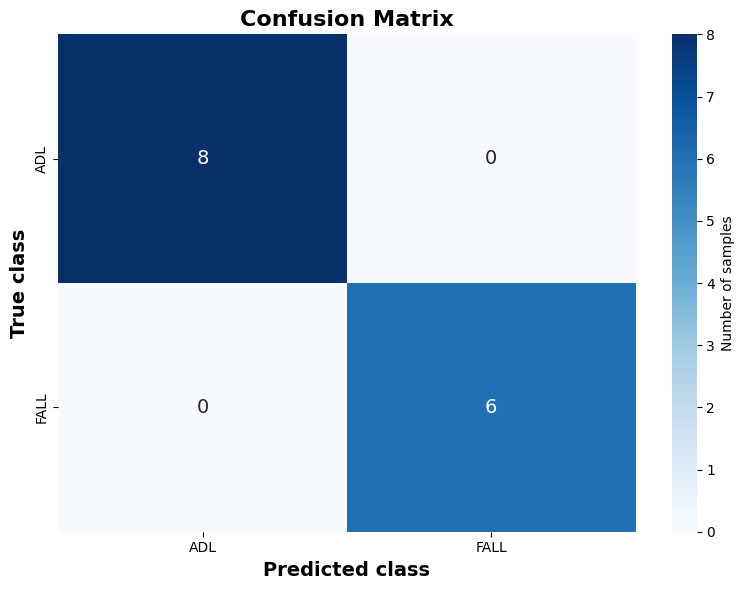

In [11]:
# cm = confusion_matrix(all_labels, all_predictions)
cm = confusion_matrix(test_true, test_preds)
class_names = ['ADL', 'FALL']

fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Number of samples'},
            annot_kws={'size': 14})

ax.set_xlabel('Predicted class', fontsize=14, fontweight='bold')
ax.set_ylabel('True class', fontsize=14, fontweight='bold')
ax.set_title('Confusion Matrix', fontsize=16, fontweight='bold')

plt.tight_layout()

## 12. Wykresy treningu

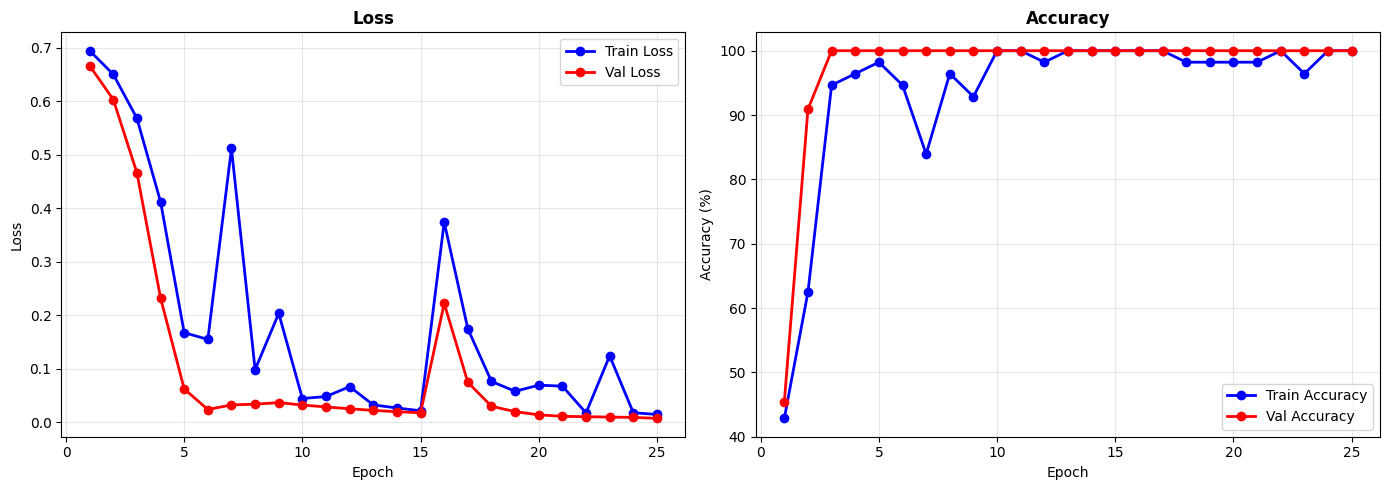

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs = range(1, len(history['train_loss']) + 1)

axes[0].plot(epochs, history['train_loss'], 'b-o', label='Train Loss', linewidth=2)
axes[0].plot(epochs, history['val_loss'], 'r-o', label='Val Loss', linewidth=2)
axes[0].set_title('Loss', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(epochs, np.array(history['train_acc'])*100, 'b-o', label='Train Accuracy', linewidth=2)
axes[1].plot(epochs, np.array(history['val_acc'])*100, 'r-o', label='Val Accuracy', linewidth=2)
axes[1].set_title('Accuracy', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 13. Analiza błędów

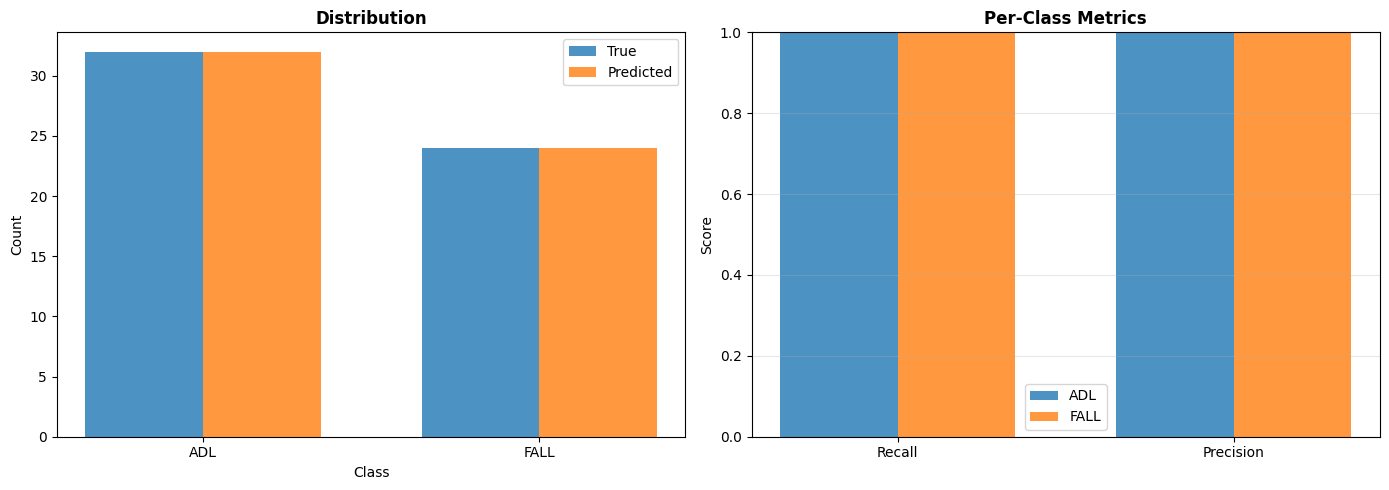

In [13]:
errors = np.where(np.array(all_predictions) != np.array(all_labels))[0]
correct = np.where(np.array(all_predictions) == np.array(all_labels))[0]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

pred_counts = np.bincount(all_predictions, minlength=2)
true_counts = np.bincount(all_labels, minlength=2)

x = np.arange(2)
width = 0.35
axes[0].bar(x - width/2, true_counts, width, label='True', alpha=0.8)
axes[0].bar(x + width/2, pred_counts, width, label='Predicted', alpha=0.8)
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(['ADL', 'FALL'])
axes[0].legend()

recall_adl = cm[0,0] / (cm[0,0] + cm[0,1]) if (cm[0,0] + cm[0,1]) > 0 else 0
recall_fall = cm[1,1] / (cm[1,0] + cm[1,1]) if (cm[1,0] + cm[1,1]) > 0 else 0
precision_adl = cm[0,0] / (cm[0,0] + cm[1,0]) if (cm[0,0] + cm[1,0]) > 0 else 0
precision_fall = cm[1,1] / (cm[0,1] + cm[1,1]) if (cm[0,1] + cm[1,1]) > 0 else 0

metrics = ['Recall', 'Precision']
adl_vals = [recall_adl, precision_adl]
fall_vals = [recall_fall, precision_fall]

x = np.arange(len(metrics))
axes[1].bar(x - width/2, adl_vals, width, label='ADL', alpha=0.8)
axes[1].bar(x + width/2, fall_vals, width, label='FALL', alpha=0.8)
axes[1].set_ylabel('Score')
axes[1].set_title('Per-Class Metrics', fontsize=12, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics)
axes[1].set_ylim([0, 1])
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()